In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import time
import matplotlib.gridspec as gridspec

import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as rmse_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(42)
random.seed(42)

In [4]:
OVERALL_PLOT = False
# for measuring modeling time

In [5]:
def nrmse_score(y_true, y_pred):
    return rmse_score(y_true, y_pred)/(np.max(y_true)-np.min(y_true))

score_func = make_scorer(nrmse_score, greater_is_better=False)

In [6]:
# read in the performance metrics for each experiment
data_all = ExprData()
data_all.load_pickle()
data_all = data_all.merge_tpch()

In [7]:
data = data_all.remove_by_wlname(['xml', 'ycsb'])
ycsb_data = data_all.remove_by_wlname(['xml', 'tpcc', 'tpch', 'twitter'])

In [8]:
candid_idx = len(ycsb_data.wl_names) - 3
all_groups = ['10', '11', '12']
candidate_group = '10'
ycsb_data = ycsb_data.remove_by_group([g for g in all_groups if g != candidate_group])

In [9]:
X_label = 'SKU'
expr_label = 'EXPR'
y_true_label = 'Y_TRUE'
y_pred_label = 'Y_PRED'
suffix_labels = ['_small', '_large']

In [10]:
# similarity for all
new_data = data.keep_complete_exprs()

scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(new_data.plan_mtxs)
perf_mtxs, perf_col_ranges = scaler.scale(new_data.perf_mtxs)

simi_calc_all = Similarity(new_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
simi_calc_all.calc_bined_mtx() # all plan features

simi_calc = simi_calc_all
fs = FeatureSelection(simi_calc)

all_top_7 = fs.select_features(7, 'fANOVA', est_name=None, direction=None, feature_type=None)

(108, 108, 22)
(108, 108, 29)


In [12]:
sampled_data = new_data.sample_data()

In [14]:
data_by_type = sampled_data.split_by_type()

In [15]:
sampled_by_type = sampled_data.split_by_type()
for ty, expr_set in sampled_by_type.items():
    sub_by_term = expr_set.split_by_term()
    sampled_by_type[ty] = sub_by_term

In [19]:
def get_cpu_nums_as_X(l):
    return np.array([int(e[3:]) for e in l]).reshape(-1, 1)

In [20]:
def scorer(skus, y_true, y_pred, expr_idxs):
    X_label = 'SKU'
    expr_label = 'EXPR'
    y_true_label = 'Y_TRUE'
    y_pred_label = 'Y_PRED'
    overall_data = pd.DataFrame(zip(skus, expr_idxs, y_true, y_pred), columns=[X_label, expr_label, y_true_label, y_pred_label])

    # for each pair of SKU
    num_cpus = np.sort(np.unique(skus))

    new_y_true, new_y_pred = [], []

    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            
            curr_smaller = overall_data[overall_data[X_label] == cpu_a]
            curr_bigger = overall_data[overall_data[X_label] == cpu_b]

            for _, smaller_row in curr_smaller.iterrows():
                curr_expr_idx = smaller_row[expr_label]
                curr_diff = smaller_row[y_true_label] - smaller_row[y_pred_label]
                bigger_row = curr_bigger[curr_bigger[expr_label] == curr_expr_idx]
                assert(bigger_row.shape[0] == 1)
                bigger_row = bigger_row.iloc[0]
                new_y_true.append(bigger_row[y_true_label])
                new_y_pred.append(bigger_row[y_pred_label] + curr_diff)
    new_y_true = np.array(new_y_true)
    new_y_pred = np.array(new_y_pred)
    return r2_score(new_y_true, new_y_pred)

In [21]:
def plot_prediction(dfs, X, y, expr_idxs, method, plot=True, show_fig=True):
    # plot all trends 
    colors = ['#1b9e77','#7570b3','#d95f02','#e7298a']
    fig, ax = plt.subplots(figsize=(4,3.6))
        
    pred_label_add = False
    pred_color = colors[0]
    overall_expr_label_add = False
    expr_tracker = 0
    
    all_true_tracker = {}
        
    color_map = [colors[1+idx%3] for idx, _ in enumerate(expr_idxs)]
    ax.scatter(X, y, color=color_map)
    
    for df in dfs:
        expr_label_add = False
        for _, row in df.iterrows():
            run_color = colors[1+expr_tracker%3]
            curr_x = [row[f'{X_label}{suffix}'] for suffix in suffix_labels]
            expr_tracker += 1
            true_y = [row[f'{y_true_label}{suffix}'] for suffix in suffix_labels]
            
            for x, y in zip(np.array(curr_x).flatten(), true_y):
                if x not in all_true_tracker:
                    all_true_tracker[x] = []
                all_true_tracker[x].append(y)
                
            if not overall_expr_label_add:
                if not expr_label_add and expr_tracker % 3 == 2:
                    expr = ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5, label='True_y')
                    expr_label_add = True
                else:
                    ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5, label='  ')
            else:
                ax.plot(curr_x, true_y, '-', color=run_color, alpha=0.5, linewidth=1.5)
        overall_expr_label_add = True
        
    for df in dfs:
        for _, row in df.iterrows():
            curr_x = [row[f'{X_label}{suffix}'] for suffix in suffix_labels]
            pred_y = [row[f'{y_true_label}{suffix_labels[0]}'], row[f'{y_pred_label}{suffix_labels[1]}']]
            
            if not pred_label_add:
                pred_label_add = True
                pred_l = ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=1, label='Predict_y')
            else:
                ax.plot(curr_x, pred_y, '-o', color=pred_color, linewidth=1)
    
    true_x = np.sort(list(all_true_tracker.keys()))
    mean_true_y = [np.mean(all_true_tracker[key]) for key in true_x]
    ax.plot(true_x, mean_true_y, '-', color='#fc8d62', linewidth=15, alpha=0.3, label='Mean_True_y')

                
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=2, mode="expand")

    # plt.legend(bbox_to_anchor=(1,0.3,),loc="lower left", ncols=1)
    plt.savefig(f'figs/prediction/ycs_pred_{method}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [22]:
'''
Use a dictionary of models
- key: (lower SKU, higher SKU)
- value: model
'''
def predict(model_dicts, X, y_true, expr_idxs, method, plot=True, show_fig=True):
    overall_data = pd.DataFrame(zip(X, expr_idxs, y_true), columns=[X_label, expr_label, y_true_label])

    # for each pair of SKU
    num_cpus = np.sort(np.unique(X))
    test_scores = []
    models, datas_big, datas_small = [], [], []
    dfs = []
    
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            
            curr_smaller = overall_data[overall_data[X_label] == cpu_a]
            curr_bigger = overall_data[overall_data[X_label] == cpu_b]
            
            new_preds = []
            
            for model_dict in model_dicts:            
                new_y_true, new_y_pred = [], []

                curr_smaller_pred = model_dict[(cpu_a, cpu_b)].predict(curr_smaller[X_label].to_numpy().reshape(-1, 1))
                curr_bigger_pred = model_dict[(cpu_a, cpu_b)].predict(curr_bigger[X_label].to_numpy().reshape(-1, 1))
                curr_smaller = curr_smaller.assign(Y_PRED=curr_smaller_pred)
                curr_bigger = curr_bigger.assign(Y_PRED=curr_bigger_pred)

                for _, smaller_row in curr_smaller.iterrows():
                    curr_expr_idx = smaller_row[expr_label]
                    curr_diff = smaller_row[y_true_label] - smaller_row[y_pred_label]
                    bigger_row = curr_bigger[curr_bigger[expr_label] == curr_expr_idx]
                    assert(bigger_row.shape[0] == 1)
                    bigger_row = bigger_row.iloc[0]
                    new_y_true.append(bigger_row[y_true_label])
                    new_y_pred.append(bigger_row[y_pred_label] + curr_diff)
                new_preds.append(new_y_pred)
            
            curr_bigger = curr_bigger.assign(Y_PRED=np.mean(np.array(new_preds), axis=0))
            df = pd.merge(curr_smaller, curr_bigger, on=[expr_label], suffixes=suffix_labels)
            dfs.append(df)
            
            new_y_true = np.array(new_y_true)
            new_y_pred = np.array(new_y_pred) 
            
            score = rmse_score(new_y_true, new_y_pred)/(np.max(new_y_true) - np.min(new_y_true))
            test_scores.append(score)
                
            models.append(model_dict[(cpu_a, cpu_b)])
            datas_small.append(curr_smaller)
            datas_big.append(curr_bigger)

    print(test_scores)
    if plot:
        plot_prediction(dfs, X, y_true, expr_idxs, method, show_fig)
    print(np.max(y) - np.min(y))
    # overall_score = np.sqrt((np.array(test_scores)**2).mean())/(np.max(y) - np.min(y))
    overall_score = np.mean(test_scores)
    return overall_score

In [23]:
'''
Use a dictionary of models
- key: (lower SKU, higher SKU)
- value: model
'''
def predict_pair(model_dicts, sku_pair, X, y_true, expr_idxs, method, plot=True, show_fig=True):
    overall_data = pd.DataFrame(zip(X, expr_idxs, y_true), columns=[X_label, expr_label, y_true_label])

    # for each pair of SKU
    num_cpus = np.sort(np.unique(X))
    test_scores = []
    models, datas_big, datas_small = [], [], []
    dfs = []
    
    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            print(i, j, sku_pair)
            if i != sku_pair[0] or j != sku_pair[1]:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            
            curr_smaller = overall_data[overall_data[X_label] == cpu_a]
            curr_bigger = overall_data[overall_data[X_label] == cpu_b]
            
            new_preds = []
            
            for model_dict in model_dicts:            
                new_y_true, new_y_pred = [], []

                curr_smaller_pred = model_dict[(cpu_a, cpu_b)].predict(curr_smaller[X_label].to_numpy().reshape(-1, 1))
                curr_bigger_pred = model_dict[(cpu_a, cpu_b)].predict(curr_bigger[X_label].to_numpy().reshape(-1, 1))
                curr_smaller = curr_smaller.assign(Y_PRED=curr_smaller_pred)
                curr_bigger = curr_bigger.assign(Y_PRED=curr_bigger_pred)

                for _, smaller_row in curr_smaller.iterrows():
                    curr_expr_idx = smaller_row[expr_label]
                    curr_diff = smaller_row[y_true_label] - smaller_row[y_pred_label]
                    bigger_row = curr_bigger[curr_bigger[expr_label] == curr_expr_idx]
                    assert(bigger_row.shape[0] == 1)
                    bigger_row = bigger_row.iloc[0]
                    new_y_true.append(bigger_row[y_true_label])
                    new_y_pred.append(bigger_row[y_pred_label] + curr_diff)
                new_preds.append(new_y_pred)
            
            curr_bigger = curr_bigger.assign(Y_PRED=np.mean(np.array(new_preds), axis=0))
            df = pd.merge(curr_smaller, curr_bigger, on=[expr_label], suffixes=suffix_labels)
            dfs.append(df)
            
            new_y_true = np.array(new_y_true)
            new_y_pred = np.array(new_y_pred) 
            
            score = rmse_score(new_y_true, new_y_pred)/(np.max(new_y_true) - np.min(new_y_true))
            test_scores.append(score)
                
            models.append(model_dict[(cpu_a, cpu_b)])
            datas_small.append(curr_smaller)
            datas_big.append(curr_bigger)
            
    print(test_scores)

    if plot:
        plot_prediction(dfs, X, y_true, expr_idxs, method, show_fig)
    overall_score = np.mean(test_scores)
    return overall_score

In [24]:
ycsb_X = get_cpu_nums_as_X(ycsb_data.cpu_nums)
ycsb_y = np.array(ycsb_data.wl_throughput)
ycsb_expr = np.array(ycsb_data.sampled_run_idx)

In [25]:
all_results = {}
all_times = {}

## Regression

Use only CPU number and target (throughput)

In [26]:
from sklearn.linear_model import LinearRegression
X_label = 'cpu_num'
y_label = 'throughput'

In [27]:
def plot_regeressions_indi(models, datas, workload_name, group_type, groupping_id, plot=True, show_fig=True):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
        
    fig, ax = plt.subplots(figsize=(4,3.6))

    for model, data, i in zip(models, datas, list(range(len(models)))):
        x_new = np.linspace(np.min(data[X_label])[0], np.max(data[X_label])[0], num=100).reshape(-1, 1)
        y_new = model.predict(x_new)
        ax.scatter(data[X_label], data[y_label], color=color)
        ax.plot(x_new, y_new, color=colors[i], linestyle='--', label='{}-{}'.format(np.min(data[X_label])[0], np.max(data[X_label])[0]))
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
 
    ax.axis('tight')
    plt.legend(loc='best', ncol=2)
    plt.savefig(f'figs/prediction/regr_pair_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [28]:
def build_regression_model_indi(X, y, expr_idxs, wl_name, grouping_type, groupping_id, plot=True, show_fig=True): 
    train_scores, test_scores = [], []

    run_label = 'RUN_IDX'
    overall_data = pd.DataFrame(zip(X, y, expr_idxs), columns=[X_label, y_label, run_label])

    k = 5
    kf = KFold(n_splits=k, shuffle=True)
    uq_idx = np.unique(expr_idxs)
    num_cpus = np.sort(np.unique(X))

    models, datas = [], []
    
    model_dict = {}
    train_time = 0

    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            datas.append(curr_data)
            start = time.time()
            # select by sampled run idx 
            for train_run_idxs, test_run_idxs in kf.split(uq_idx):
                train_runs = uq_idx[train_run_idxs]
                test_runs = uq_idx[test_run_idxs]
                train_index = [i for i, value in enumerate(curr_data[run_label].to_list()) if value in train_runs]
                test_index = [i for i, value in enumerate(curr_data[run_label].to_list()) if value in test_runs]
                
                data = curr_data.iloc[train_index]
                test = curr_data.iloc[test_index]
                
                reg = LinearRegression()
                reg.fit(data[[X_label]], data[y_label])
                test_pred = reg.predict(test[[X_label]])
                train_pred = reg.predict(data[[X_label]])

                score = rmse_score(test[y_label], test_pred)/(np.max(test[y_label]) - np.min(test[y_label]))
                test_scores.append(score)
                
                score = rmse_score(data[y_label], train_pred)/(np.max(data[y_label]) - np.min(data[y_label]))
                train_scores.append(score)
            end = time.time()
            train_time += (end - start) / k
            
            models.append(reg)
            model_dict[(cpu_a, cpu_b)] = reg
                        
    # plot the last one as example
    if plot:
        plot_regeressions_indi(models, datas, wl_name, grouping_type, groupping_id, show_fig)
    overall_test = np.mean(test_scores)
    overall_train = np.mean(train_scores)

    return overall_test, overall_train, model_dict, train_time

In [29]:
all_tests, all_trains = [], []
group_to_model_dict = {} 
all_results['Regression'] = {}
all_times['Regression'] = {}
for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['Regression']:
        all_results['Regression'][name] = {}    
        all_times['Regression'][name] = {}

    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, model_dict, train_time = build_regression_model_indi(X, y, np.array(curr_data.sampled_run_idx), name, 'group', curr_data.wl_groups[0], plot=OVERALL_PLOT, show_fig=True)
    group_to_model_dict[ty] = model_dict
    print('Test rmse         = {}, Train rmse         = {}'.format(test_r2_mean, train_r2_mean)) 
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['Regression'][name][term] = test_r2_mean
    all_times['Regression'][name][term] = train_time

print('Overall test nrmse: {}; train {}'.format(np.mean(all_tests), np.mean(all_tests)))

Group Id: 1, wl name tpcc, terminal num 32
Test rmse         = 0.2920315754652549, Train rmse         = 0.22625319349140013
Group Id: 2, wl name tpch, terminal num 1
Test rmse         = 0.24265651626780382, Train rmse         = 0.19071177833764222
Group Id: 3, wl name twitter, terminal num 32
Test rmse         = 0.3282252388735014, Train rmse         = 0.23155076155216017
Group Id: 4, wl name twitter, terminal num 8
Test rmse         = 0.28932360014886577, Train rmse         = 0.23762113459505
Group Id: 7, wl name tpcc, terminal num 8
Test rmse         = 0.3046838683771656, Train rmse         = 0.2538041404687983
Group Id: 8, wl name tpcc, terminal num 4
Test rmse         = 0.2829773557832245, Train rmse         = 0.2247771584941554
Group Id: 9, wl name twitter, terminal num 4
Test rmse         = 0.34267156586293623, Train rmse         = 0.2737987998003151
Overall test nrmse: 0.2975099601112503; train 0.2975099601112503


[0.07389151048990596, 0.07881305059258885, 0.8308475160186006, 0.052013420320252496, 0.7008195315061003, 0.6392257392320971]


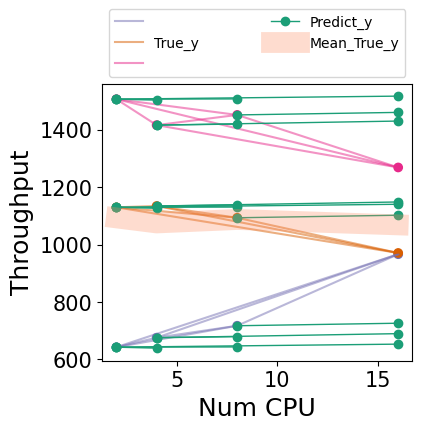

298.8083333333334
Overall ycsb nrmse: 0.39593512802659087


In [30]:
# most similar expr idx
min_run_idx = 0
min_groups = ['8', '7'] # '1' '2' '5' '6']

model_dict = [group_to_model_dict[min_group] for min_group in min_groups]

overall_score = predict(model_dict, ycsb_X, ycsb_y, ycsb_expr, 'regression', True)

print('Overall ycsb nrmse: {}'.format(overall_score))

## SVM

Use only CPU number and target (throughput)

In [31]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [32]:
def plot_svrs_indi(models, datas, workload_name, group_type, groupping_id, plot=True, show_fig=True):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
    fig, ax = plt.subplots(figsize=(4,3.6))

    for model, data, line_color in zip(models, datas, colors):
        x_new = np.linspace(np.min(data[X_label]), np.max(data[X_label]), num=100).reshape(-1, 1)
        y_new = model.predict(x_new)
        ax.scatter(data[X_label], data[y_label], color=color)
        # ax.plot(x_new, y_new, color=color, linestyle='--')
        ax.plot(x_new, y_new, color=line_color, linestyle='--', label='{}-{}'.format(np.min(data[X_label])[0], np.max(data[X_label])[0]))

    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.legend(loc='best', ncol=2)
    plt.savefig(f'figs/prediction/svr_pair_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [33]:
def build_svm_model_indi(X, y, wl_name, grouping_type, groupping_id, plot=True, show_fig=True):  
    metrics = [X_label, y_label]
    zipped = zip(X, y)
    
    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)

    train_scores, test_scores = [], []

    models, datas = [], []
    model_dict = {}
    
    # epsilon range: according to this paper: http://adrem.uantwerpen.be/bibrem/pubs/IJCNN2007.pdf
    # C range: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
    
    # Cross validation grid search (best parameters) 
    c_range = np.logspace(-5, 5, base=2.0, num=5) 
    epsilon_range = np.linspace(10 ** -3, 1, 5)
    degree_range = np.array(list(range(1, 5)))
    tuned_parameters = [{'kernel': ['rbf'],'C': c_range, 'epsilon': epsilon_range}, 
                        {'kernel': ['linear'], 'C': c_range, 'epsilon': epsilon_range}, 
                        {'kernel': ['poly'], 'C': c_range, 'degree': degree_range, 'epsilon': epsilon_range}
                       ]

    num_cpus = np.sort(np.unique(X))
    prev_cpu = num_cpus[0]
    
    train_time = 0

    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            
            svr = SVR()
            datas.append(curr_data)
            clf = GridSearchCV(svr,param_grid=tuned_parameters,verbose=0, n_jobs=4,
                               cv=5, 
                               scoring=score_func, 
                               return_train_score=True)
            clf.fit(curr_data[[X_label]], curr_data[y_label])           
            best_params = clf.best_params_
            results = pd.DataFrame.from_dict(clf.cv_results_)
            results_best = results[results['params'] == best_params].reset_index()
            train_time += results_best['mean_fit_time'][0]
            
#             print("writing", cpu_a, cpu_b)
#             with open(f"model_pkl/svm_pairwise{groupping_id}-{i}-{j}.pkl", "wb") as f:
#                 pickle.dump(clf, f)

            test_scores.append(results_best.iloc[0]['mean_test_score'])
            train_scores.append(results_best.iloc[0]['mean_train_score'])
            models.append(clf)
            model_dict[(cpu_a, cpu_b)] = clf
            print(f'NRMSE from {cpu_a} to {cpu_b} is {test_scores[-1]}')

    # plot the last one as example
    if plot:
        plot_svrs_indi(models, datas, wl_name, grouping_type, groupping_id, show_fig)

    overall_test = np.mean(test_scores)
    overall_train = np.mean(train_scores)
    return overall_test, overall_train, model_dict, train_time

In [34]:
all_tests, all_trains = [], []
group_to_model_dict = {}
all_results['SVM'] = {}
all_times['SVM'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['SVM']:
        all_results['SVM'][name] = {}
        all_times['SVM'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, model_dict, train_time = build_svm_model_indi(X, y, 
                                                                               curr_data.wl_names[0], 'group', 
                                                                               curr_data.wl_groups[0], 
                                                                               plot=OVERALL_PLOT, show_fig=False)
    group_to_model_dict[ty] = model_dict
    print('Test rmse = {}, Train rmse = {}'.format(test_r2_mean, train_r2_mean))     
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['SVM'][name][term] = test_r2_mean
    all_times['SVM'][name][term] = train_time

print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_tests)))

Group Id: 1, wl name tpcc, terminal num 32
NRMSE from 2 to 4 is -0.35117226873562335
NRMSE from 2 to 8 is -0.29872469103129273
NRMSE from 2 to 16 is -0.23012122145633823
NRMSE from 4 to 8 is -0.29734154545336466
NRMSE from 4 to 16 is -0.23761594275940084
NRMSE from 8 to 16 is -0.2664438312781213
Test rmse = -0.28023658345235686, Train rmse = -0.2443920644221206
Group Id: 2, wl name tpch, terminal num 1
NRMSE from 2 to 4 is -0.24111660919297914
NRMSE from 2 to 8 is -0.24534950415239692
NRMSE from 2 to 16 is -0.24751495905979898
NRMSE from 4 to 8 is -0.24280938312546718
NRMSE from 4 to 16 is -0.2447207194693864
NRMSE from 8 to 16 is -0.2512322467655542
Test rmse = -0.24545723696093047, Train rmse = -0.19383693724767778
Group Id: 3, wl name twitter, terminal num 32
NRMSE from 2 to 4 is -0.31031254925828466
NRMSE from 2 to 8 is -0.3166111701347448
NRMSE from 2 to 16 is -0.293607341777806
NRMSE from 4 to 8 is -0.30369581715298477
NRMSE from 4 to 16 is -0.27886558958347046
NRMSE from 8 to 16

[0.07364725390604053, 0.07886102119097921, 0.8307924980854298, 0.05188096558016448, 0.7006287599392236, 0.6379466356468979]


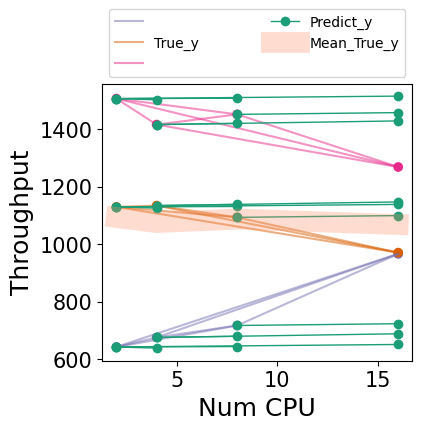

298.8083333333334
Overall ycsb nrmse: 0.3956261890581225


In [35]:
# most similar expr idx
min_run_idx = 0

model_dict = [group_to_model_dict[min_group] for min_group in min_groups]
simi_expr = data_all.get_by_run_idx(min_run_idx)

overall_score = predict(model_dict, ycsb_X, ycsb_y, ycsb_expr, 'svm', True)

print('Overall ycsb nrmse: {}'.format(overall_score))

0 0 (0, 2)
0 1 (0, 2)
0 2 (0, 2)
0 3 (0, 2)
1 1 (0, 2)
1 2 (0, 2)
1 3 (0, 2)
2 2 (0, 2)
2 3 (0, 2)
3 3 (0, 2)
[0.07886102119097921]


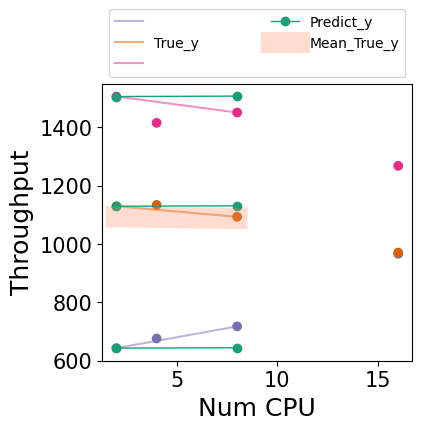

Overall ycsb nrmse: 0.07886102119097921


In [36]:
# most similar expr idx
min_run_idx = 0

model_dict = [group_to_model_dict[min_group] for min_group in min_groups]
simi_expr = data_all.get_by_run_idx(min_run_idx)

overall_score = predict_pair(model_dict, (0, 2), ycsb_X, ycsb_y, ycsb_expr, 'svm-2-8', True)

print('Overall ycsb nrmse: {}'.format(overall_score))

## LME 

#### Per run

In [37]:
random_effect = 'EXPR_ID'
fixed_effect = 'SKU_VALUE'
target_metric = 'throughput'

In [38]:
import statsmodels
print(statsmodels.__version__)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

0.14.0


In [39]:
def plot_lmm_graphs_indi(model_parameters_dfs, fixed_effects_covs, datas, groups, metric, fig_name, plot=True, show_fig=True):
    n_groups = groups.size
    # fig, axs = plt.subplots(1, n_groups, figsize=(n_groups*12, 9), sharey=True, sharex=True)
    color_map = ["darkorange", "limegreen", "royalblue"] #, "#2ecc71"]


    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
    fig, axs = plt.subplots(1,3, figsize=(12, 4), sharey=True)

    for model_parameters_df, fixed_effects_cov, data, line_color in zip(model_parameters_dfs, fixed_effects_covs, datas, colors):
        t = np.linspace(np.min(data[fixed_effect]), np.max(data[fixed_effect]), num=100)
        for expr_idx, c, ax in zip(groups, color_map, axs):
            group_data = data.loc[data[random_effect] == expr_idx]
            group_data.plot.scatter(fixed_effect, metric, ax=ax, color=c)
            group_params = model_parameters_df.loc[expr_idx]
            # group_params = model_parameters_df.loc[model_parameters_df[random_effect] == expr_idx]|
            regression_line = group_params['alpha'] + group_params['beta'] * t
            # ax.plot(t, regression_line, color=c, linestyle='--')
            ax.plot(t, regression_line, color=line_color, linestyle='--', label='{}-{}'.format(np.min(data[fixed_effect]), np.max(data[fixed_effect])))

            # This is derived by expanding the following expression using the bi-linearity of covariance:
            #     var(alpha_fe + alpha_re + (beta_fe + beta_re) * t)
            prediction_sd = np.sqrt(
                group_params['var_alpha'] + 2 * t * group_params['cov_alpha_beta'] + group_params['var_beta'] * t**2
                + fixed_effects_cov['intercept'] + 2 * t * fixed_effects_cov['intercept_slope'] + fixed_effects_cov['slope'] * t**2
            )
            upper_band, lower_band = regression_line + 2 * prediction_sd, regression_line - 2 * prediction_sd
            ax.fill_between(t, upper_band, lower_band, alpha=0.05, color=c)
    # ax.set_title(fig_name)
    for ax in axs:
        ax.set_xlabel('Num CPU')
        ax.set_ylabel('Throughput')
    plt.legend(loc='best', ncol=2)

    plt.savefig(f'figs/prediction/lmm_pair_nosd_{fig_name}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close()

In [40]:
def build_lmm_models_indi(X, y, expr_ids, feature_names, fig_name, plot=True, num_bins=10):

    metrics = [fixed_effect, random_effect, target_metric]
    zipped = zip(X, expr_ids, y)
    
    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)

    train_rmses, test_rmses = [], []

    model_parameters_dfs = []
    fixed_effects_covs = []
    datas = []
    model_dict = {}
    
    k = 5
    kf = KFold(n_splits=k, shuffle=True)

    num_cpus = np.sort(np.unique(X))
    
    train_time = 0

    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[fixed_effect] == cpu_a) | (overall_data[fixed_effect] == cpu_b) ]
            start = time.time()
            for train_index, test_index in kf.split(curr_data):
                data = curr_data.iloc[train_index]
                test = curr_data.iloc[test_index]
                with warnings.catch_warnings():
                    # Parameter is often on the boundary
                    warnings.simplefilter("ignore", ConvergenceWarning)
                    md = smf.mixedlm("{} ~ SKU_VALUE".format(target_metric), data, groups=data[random_effect], re_formula="~SKU_VALUE")
                    # groups to sku type and 
                    mdf = md.fit(method=["cg"])#, max_iter=1000)
                y_predict = mdf.fittedvalues
                test_pred = mdf.predict(exog=test)
        
                rmse = rmse_score(test[target_metric].to_list(), test_pred)
                n_rmse = nrmse_score(test[target_metric], test_pred)
                test_rmses.append(n_rmse)
        
                rmse = rmse_score(data[target_metric].to_list(), y_predict)
                n_rmse = nrmse_score(data[target_metric], y_predict)
                train_rmses.append(n_rmse)
                fe, re, recov = mdf.fe_params, mdf.random_effects, mdf.random_effects_cov
            end = time.time()
            train_time += (end - start)/k
            
            groups = data[random_effect].unique()       
            model_parameters_df = pd.DataFrame([
                [fe[0] + re[idx][0], fe[1] + re[idx][1], recov[idx].iloc[0, 0], recov[idx].iloc[0, 1], recov[idx].iloc[1, 1]]
                for idx in groups
            ], columns=['alpha', 'beta', 'var_alpha', 'cov_alpha_beta', 'var_beta'], index=groups)
    
            fixed_effects_cov = {
                'intercept': mdf.cov_params().loc['Intercept', 'Intercept'],
                'slope': mdf.cov_params().loc[fixed_effect, fixed_effect],
                'intercept_slope': mdf.cov_params().loc['Intercept', fixed_effect],
            }
            
            datas.append(data)
            model_parameters_dfs.append(model_parameters_df)
            fixed_effects_covs.append(fixed_effects_cov)
                
    # calculate overall rmse
    overall_train_rmse = np.mean(train_rmses)
    overall_test_rmse = np.mean(test_rmses)
    if plot:
        plot_lmm_graphs_indi(model_parameters_dfs, fixed_effects_covs, datas, groups, target_metric, fig_name+"_"+target_metric, plot=True, show_fig=True)
    return overall_test_rmse, overall_train_rmse, train_time

In [41]:
all_tests, all_trains = [], []
all_results['LMM'] = {}
all_times['LMM'] = {}

for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['LMM']:
        all_results['LMM'][name] = {}
        all_times['LMM'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')

    X = get_cpu_nums_as_X(curr_data.cpu_nums).flatten()
    y = curr_data.wl_throughput
    out_name = '{}_group{}_term{}'.format(curr_data.wl_names[0], ty, curr_data.terminal_num[0])
    
    expr_idxs = list(map(int, curr_data.run_idx))

    test_r2_mean, train_r2_mean, train_time = build_lmm_models_indi(X, y, expr_idxs, all_top_7, out_name, plot=OVERALL_PLOT, num_bins=10)
    print('Test rmse = {}, Train rmse = {}'.format(test_r2_mean, train_r2_mean))  
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['LMM'][name][term] = test_r2_mean
    all_times['LMM'][name][term] = train_time

print('Overall test nrmse: {}; train {}'.format(np.mean(all_tests), np.mean(all_trains)))

Group Id: 1, wl name tpcc, terminal num 32
Test rmse = 0.27875015953171467, Train rmse = 0.06704129460267459
Group Id: 2, wl name tpch, terminal num 1
Test rmse = 0.23725091865134387, Train rmse = 0.183846574527247
Group Id: 3, wl name twitter, terminal num 32
Test rmse = 0.3056251726225947, Train rmse = 0.10871703755157829
Group Id: 4, wl name twitter, terminal num 8
Test rmse = 0.2817274531791089, Train rmse = 0.06416735064583358
Group Id: 7, wl name tpcc, terminal num 8
Test rmse = 0.29516014728129203, Train rmse = 0.0684444755312792
Group Id: 8, wl name tpcc, terminal num 4
Test rmse = 0.28324409330511835, Train rmse = 0.07741389324097521
Group Id: 9, wl name twitter, terminal num 4
Test rmse = 0.30456300698189315, Train rmse = 0.03290174812554001
Overall test nrmse: 0.28376013593615224; train 0.08607605346073256


## Gradient Boosting

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
def plot_gbs_indi(models, datas, workload_name, group_type, groupping_id, plot=True, show_fig=True):
    colors = sns.color_palette()
    if workload_name == 'tpcc':
        color = colors[0]
    elif workload_name == 'tpch':
        color = colors[1]
    elif workload_name == 'twitter':
        color = colors[2]
    else:
        color = colors[3]
        
    fig, ax = plt.subplots(figsize=(4,3.6))

    for model, data in zip(models, datas):
        x_new = np.linspace(np.max(data[X_label]), np.min(data[X_label]), num=100).reshape(-1, 1)
        y_new = model.predict(x_new)
        ax.scatter(data[X_label], data[y_label], color=color)
        ax.plot(x_new, y_new, color=color, linestyle='--')
    
    ax.set_xlabel('Num CPU')
    ax.set_ylabel('Throughput')
    
    ax.axis('tight')
    plt.savefig(f'figs/prediction/gb_pair_{workload_name}_{group_type}_{groupping_id}.pdf', bbox_inches = 'tight')
    if show_fig:
        plt.show()
    else:
        plt.close() 

In [44]:
def build_gb_model_indi(X, y, wl_name, grouping_type, groupping_id, plot=True, show_fig=True):  
    metrics = [X_label, y_label]
    zipped = zip(X, y)
    
    # append fixed effect and random effect to data
    overall_data = pd.DataFrame(zipped, columns=metrics)

    train_scores, test_scores = [], []

    models, datas = [], []
    model_dict = {}

    tuned_parameters = {
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "n_estimators":[10, 50, 100]
    }

    num_cpus = np.sort(np.unique(X))
    prev_cpu = num_cpus[0]
    
    train_time = 0

    for i in range(len(num_cpus)):
        for j in range(i, len(num_cpus)):
            if i == j:
                continue
            cpu_a = num_cpus[i] # smaller
            cpu_b = num_cpus[j] # larger
            curr_data = overall_data[ (overall_data[X_label] == cpu_a) | (overall_data[X_label] == cpu_b) ]
            
            datas.append(curr_data)
            model = GradientBoostingRegressor()
            clf = GridSearchCV(model, param_grid=tuned_parameters,verbose=0, n_jobs=-1,
                               cv=5, 
                               scoring=score_func, 
                               return_train_score=True)
            clf.fit(curr_data[[X_label]], curr_data[y_label])

            best_params = clf.best_params_
            results = pd.DataFrame.from_dict(clf.cv_results_)
            results_best = results[results['params'] == best_params].reset_index()
            train_time += results_best['mean_fit_time'][0]
            
            test_scores.append(results_best.iloc[0]['mean_test_score'])
            train_scores.append(results_best.iloc[0]['mean_train_score'])
            models.append(clf)
            model_dict[(cpu_a, cpu_b)] = clf

    if plot:
        # plot the last one as example
        plot_gbs_indi(models, datas, wl_name, grouping_type, groupping_id, show_fig)

    overall_test = np.mean(test_scores)
    overall_train = np.mean(train_scores)
    return overall_test, overall_train, model_dict, train_time

In [45]:
all_tests, all_train = [], []
group_to_model_dict = {} 
all_results['GB'] = {}
all_times['GB'] = {}
for ty, curr_data in data_by_type.items():
    name = curr_data.wl_names[0]
    term = curr_data.terminal_num[0]
    if name not in all_results['GB']:
        all_results['GB'][name] = {}
        all_times['GB'][name] = {}
    print(f'Group Id: {ty}, wl name {name}, terminal num {term}')
    
    X = get_cpu_nums_as_X(curr_data.cpu_nums)
    y = np.array(curr_data.wl_throughput)
    test_r2_mean, train_r2_mean, model_dict, train_time = build_gb_model_indi(X, y, curr_data.wl_names[0], 'group', 
                                                                              curr_data.wl_groups[0], 
                                                                              plot=OVERALL_PLOT, show_fig=True)
    print('Test rmse = {}, Train rmse = {}'.format(test_r2_mean, train_r2_mean))    

    group_to_model_dict[ty] = model_dict
    all_tests.append(test_r2_mean)
    all_trains.append(train_r2_mean)
    all_results['GB'][name][term] = test_r2_mean
    all_times['GB'][name][term] = train_time

print('Overall test nrmse: {}, train {}'.format(np.mean(all_tests), np.mean(all_trains)))

Group Id: 1, wl name tpcc, terminal num 32
Test rmse = -0.2597750596810612, Train rmse = -0.2273105639536037
Group Id: 2, wl name tpch, terminal num 1
Test rmse = -0.2419285007018237, Train rmse = -0.19083554802328329
Group Id: 3, wl name twitter, terminal num 32
Test rmse = -0.28657433302228796, Train rmse = -0.23094251933699936
Group Id: 4, wl name twitter, terminal num 8
Test rmse = -0.27538818130423987, Train rmse = -0.23874071646471515
Group Id: 7, wl name tpcc, terminal num 8
Test rmse = -0.2868715308508863, Train rmse = -0.2558586648356485
Group Id: 8, wl name tpcc, terminal num 4
Test rmse = -0.2578967607872775, Train rmse = -0.2254561004695691
Group Id: 9, wl name twitter, terminal num 4
Test rmse = -0.29214255106505344, Train rmse = -0.2755759639866194
Overall test nrmse: -0.27151098820180425, train -0.07444197877466505


[0.07363826360538381, 0.07863176431867706, 0.8306995155154189, 0.05167688909967894, 0.7005092568740637, 0.6392787479967742]


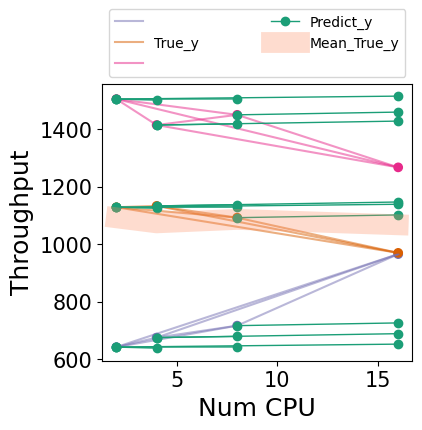

298.8083333333334
Overall ycsb nrmse: 0.3957390729016661


In [46]:
# most similar expr idx
min_run_idx = 0
# min_group = '1'

model_dict = [group_to_model_dict[min_group] for min_group in min_groups]
simi_expr = data_all.get_by_run_idx(min_run_idx)

overall_score = predict(model_dict, ycsb_X, ycsb_y, ycsb_expr, 'gb', True)

print('Overall ycsb nrmse: {}'.format(overall_score))

In [47]:
terminals = [4, 8, 32]
workloads = ['tpcc', 'twitter', 'tpch']
methods = ['Regression', 'SVM', 'LMM', 'GB']

for me in methods:
    curr_line = ''
    scs = []
    times = []
    for wl in workloads:
        if wl == 'tpch':
            sc = abs(all_results[me][wl][1])
            curr_line += f' {sc:.3f} &'
            scs.append(sc)
            times.append(all_times[me][wl][1])
        else:
            for ter in terminals:
                sc = abs(all_results[me][wl][ter])
                curr_line += f' {sc:.3f} &'
                scs.append(sc)
                times.append(all_times[me][wl][ter])
    curr_line += f' {np.mean(scs):.3}'
    curr_line += " \\\\ \cline{2-11}"
    curr_line = f'& {me} & ' + f' {np.mean(times):.4f} & ' + curr_line
    print(curr_line)

& Regression &  0.0645 &  0.283 & 0.305 & 0.292 & 0.343 & 0.289 & 0.328 & 0.243 & 0.298 \\ \cline{2-11}
& SVM &  0.0221 &  0.265 & 0.291 & 0.280 & 0.308 & 0.277 & 0.294 & 0.245 & 0.28 \\ \cline{2-11}
& LMM &  1.4818 &  0.283 & 0.295 & 0.279 & 0.305 & 0.282 & 0.306 & 0.237 & 0.284 \\ \cline{2-11}
& GB &  0.5510 &  0.258 & 0.287 & 0.260 & 0.292 & 0.275 & 0.287 & 0.242 & 0.272 \\ \cline{2-11}
